In [ ]:
import os
import glob
import math
import random
from collections import Counter, defaultdict
from abc import ABC, abstractmethod

# --- Data Science & Math ---
import numpy as np
import pandas as pd

# --- Graph & Networks ---
import networkx as nx
import community.community_louvain as louvain # pip install python-louvain

# --- Visualization ---
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- Machine Learning & Deep Learning ---
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    adjusted_rand_score, 
    normalized_mutual_info_score
)

# --- CONFIGURATION GLOBALE ---
# Ajustez ce chemin selon votre dossier
DATA_PATH = '/home/ubuntu/Videos/PROJET nsgl/fb100/data'

In [ ]:
DATA_PATH = '/home/ubuntu/Videos/PROJET nsgl/fb100/data'
FILENAME = 'Caltech36.gml' 
filepath = os.path.join(DATA_PATH, FILENAME)

if os.path.exists(filepath):
    print(f"Chargement de {FILENAME}...")
    G = nx.read_gml(filepath)
    
    # Extraction de l'attribut 'gender' pour tous les nœuds
    # .get('gender', 0) signifie : si l'attribut n'existe pas, on met 0
    genders = [G.nodes[n].get('gender', 0) for n in G.nodes()]
    
    # Comptage
    counts = Counter(genders)
    
    print("\n--- Distribution du Genre ---")
    print(f"Code 1 (Femme)   : {counts.get(1, 0)}")
    print(f"Code 2 (Homme)   : {counts.get(2, 0)}")
    print(f"Code 0 (Inconnu) : {counts.get(0, 0)}")
    
    total = len(G.nodes())
    missing_percent = (counts.get(0, 0) / total) * 100
    print(f"\nTotal nœuds : {total}")
    print(f"Pourcentage de données manquantes : {missing_percent:.2f}%")
    
else:
    print("Fichier introuvable.")

Chargement de Caltech36.gml...

--- Distribution du Genre ---
Code 1 (Femme)   : 228
Code 2 (Homme)   : 475
Code 0 (Inconnu) : 66

Total nœuds : 769
Pourcentage de données manquantes : 8.58%


Chargement de Caltech36.gml...
Calcul de la disposition (Layout)...


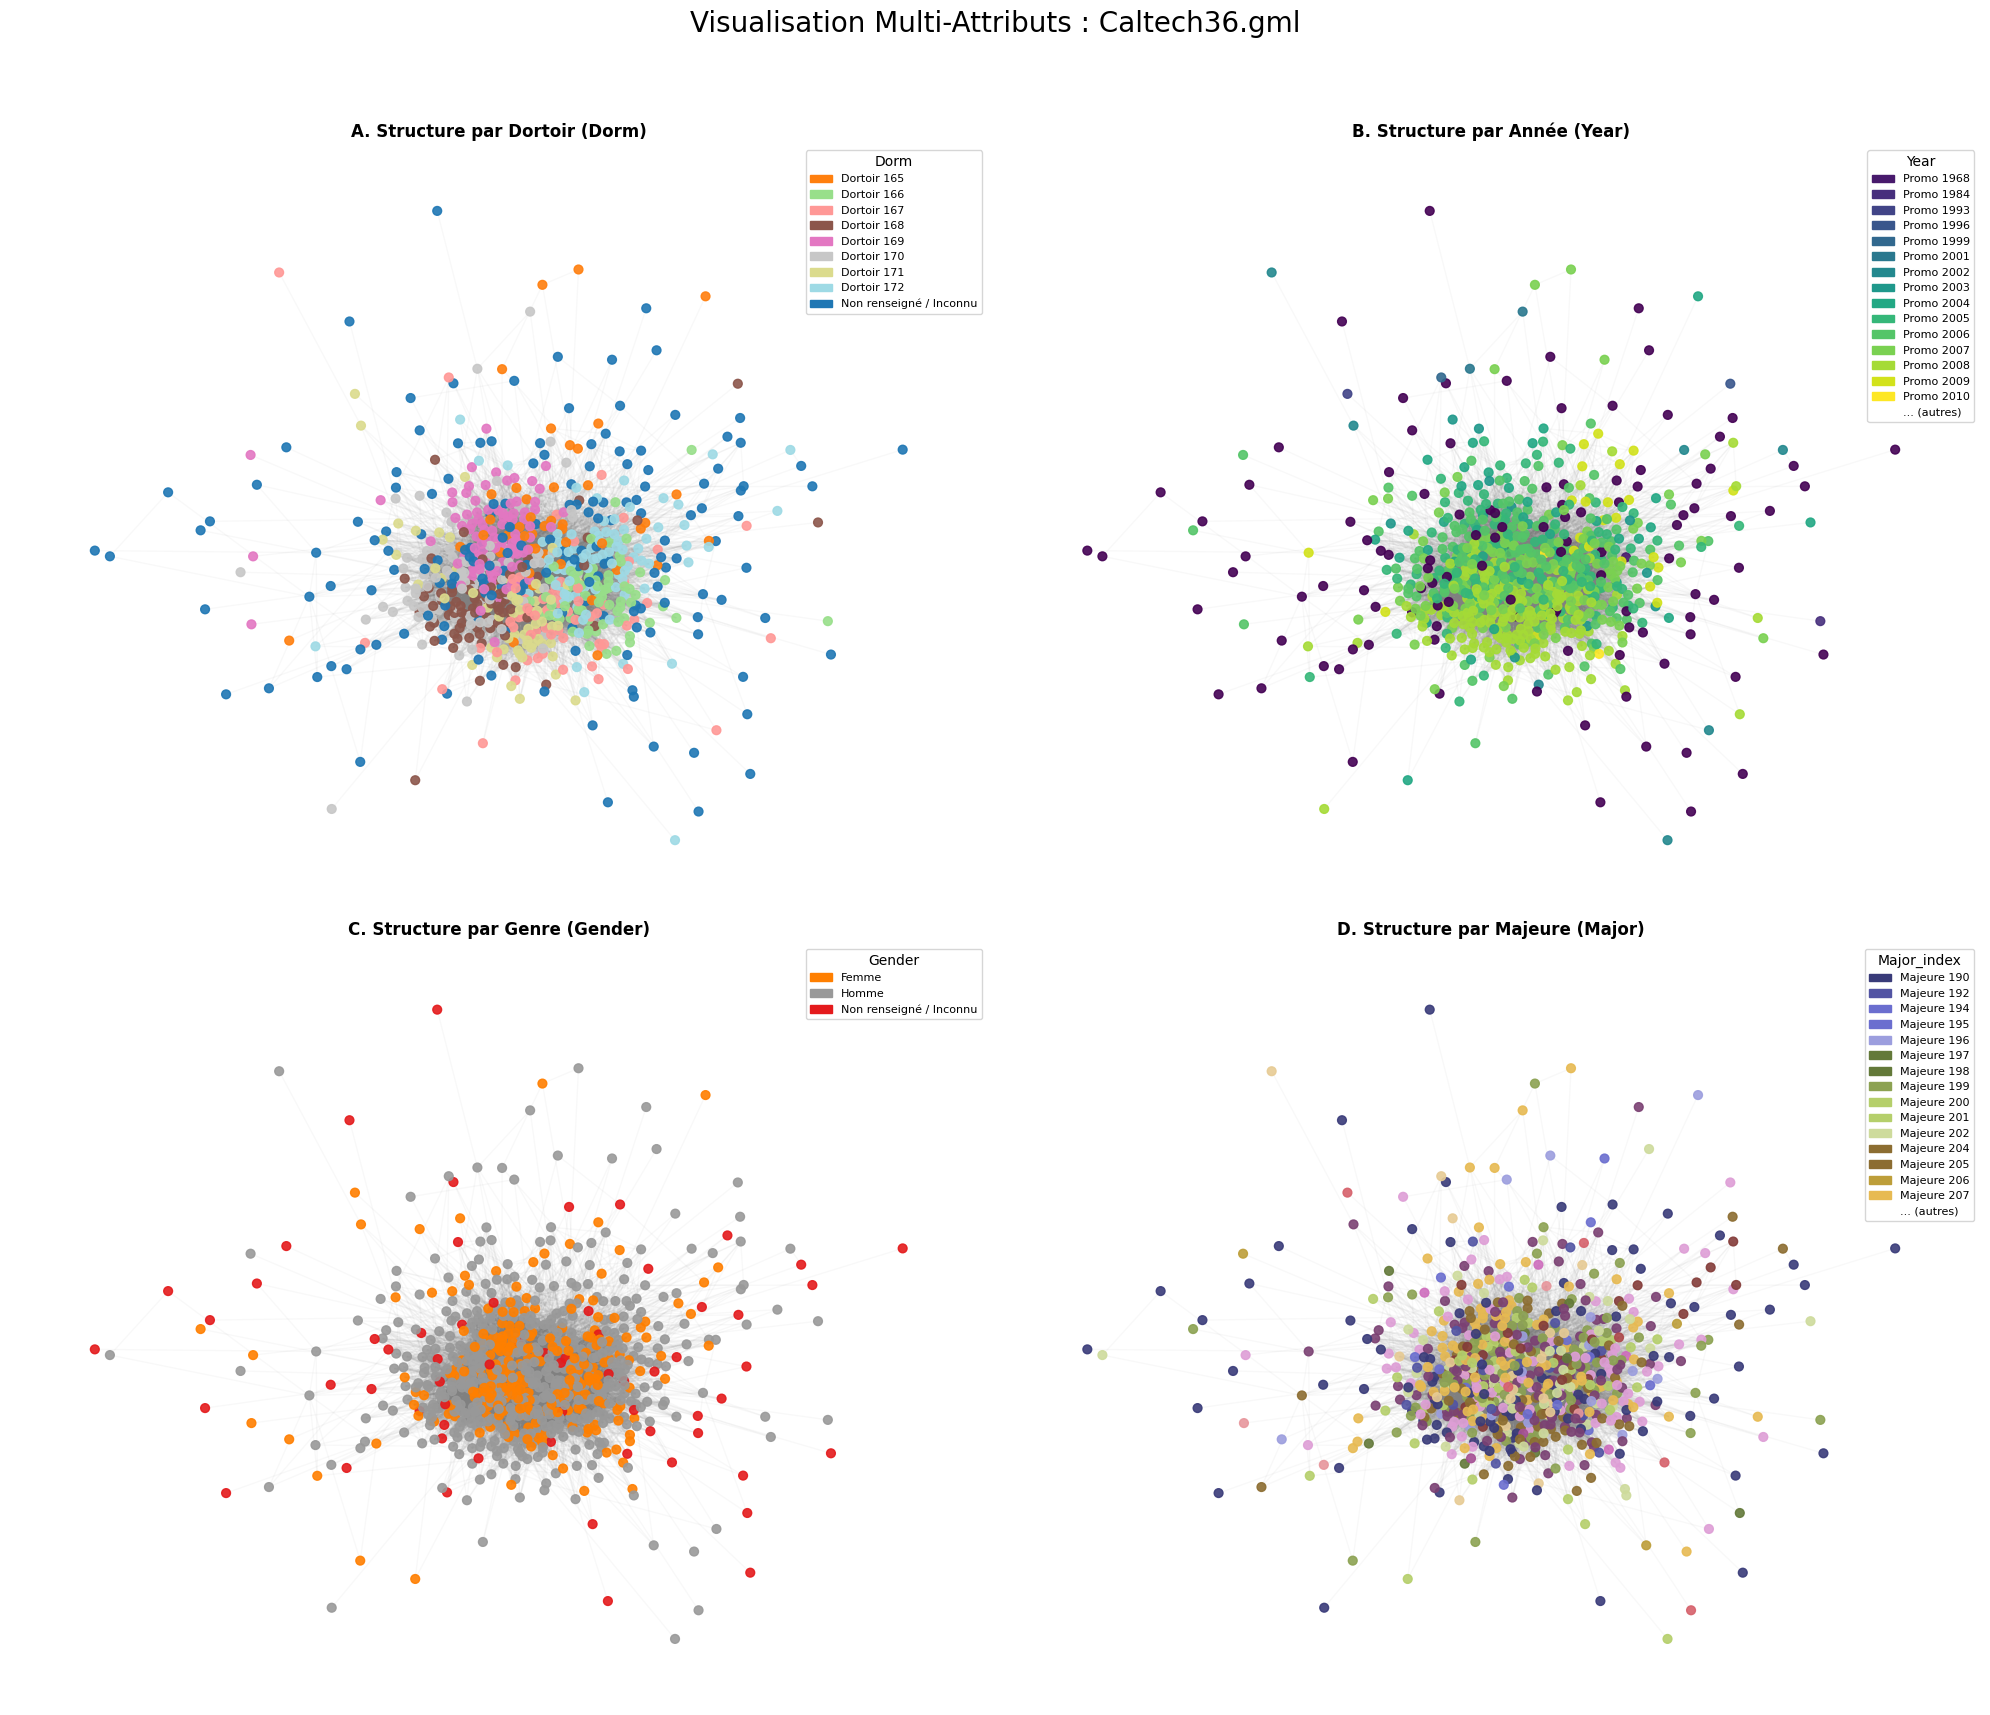


DICTIONNAIRE DES DONNÉES (À utiliser pour vos explications)

--- 1. GENRE (Gender) ---
Code 1 (Femme)   : 227 étudiants
Code 2 (Homme)   : 472 étudiants
Code 0 (Inconnu) : 63 étudiants (Donnée manquante)

--- 2. ANNÉE (Year) ---
Années présentes : de 1968 à 2010
Non renseigné (0): 111 étudiants
Top 3 Promos : [(2008, 173), (2006, 152), (2007, 133)]

--- 3. DORTOIR (Dorm) ---
Nombre de dortoirs différents : 8
Non renseigné (0) : 168 étudiants (Hors campus ?)

--- 4. MAJEURE (Major) ---
Nombre de majeures différentes : 31


In [ ]:
DATA_PATH = '/home/ubuntu/Videos/PROJET nsgl/fb100/data'
FILENAME = 'Caltech36.gml' 
filepath = os.path.join(DATA_PATH, FILENAME)

# --- DICTIONNAIRES DE TRADUCTION (A ajuster selon vos observations) ---
# Dans FB100, 0 est toujours la donnée manquante
gender_labels = {1: 'Femme', 2: 'Homme', 0: 'Inconnu'}
# Pour l'année, 0 est inconnu, les autres sont l'année de promo
# Pour les dortoirs et majeures, ce sont des codes anonymisés

def get_readable_label(attribute, value):
    """Traduit une valeur numérique en texte humain."""
    if value == 0:
        return "Non renseigné / Inconnu"
    
    if attribute == 'gender':
        return gender_labels.get(value, str(value))
    
    if attribute == 'year':
        return f"Promo {value}"
    
    if attribute == 'dorm':
        return f"Dortoir {value}"
    
    if attribute == 'major_index':
        return f"Majeure {value}"
    
    return str(value)

def analyze_and_plot(ax, G, pos, attribute, title, cmap_name):
    """Dessine le graphe et affiche les stats."""
    values = [G.nodes[n].get(attribute, 0) for n in G.nodes()]
    unique_vals = sorted(list(set(values)))
    
    # Choix des couleurs
    cmap = plt.get_cmap(cmap_name, len(unique_vals))
    val_to_color = {val: cmap(i) for i, val in enumerate(unique_vals)}
    node_colors = [val_to_color[v] for v in values]
    
    # Dessin
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.05, edge_color='gray')
    nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=G.nodes(),
                           node_color=node_colors, node_size=40, alpha=0.9)
    
    # Création de la légende (Limité à 15 éléments pour ne pas saturer)
    legend_handles = []
    # On trie pour mettre "Inconnu" (0) à la fin ou au début selon préférence
    sorted_unique = sorted(unique_vals, key=lambda x: (x==0, x)) 
    
    for val in sorted_unique[:15]: # On affiche max 15 catégories dans la légende
        label_text = get_readable_label(attribute, val)
        patch = mpatches.Patch(color=val_to_color[val], label=label_text)
        legend_handles.append(patch)
        
    if len(unique_vals) > 15:
        legend_handles.append(mpatches.Patch(color='white', label='... (autres)'))

    ax.legend(handles=legend_handles, title=attribute.capitalize(), fontsize=8, loc='best')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis('off')
    
    # RETOURNER LES STATS POUR L'UTILISATEUR
    counts = Counter(values)
    return counts

# --- MAIN EXECUTION ---
if not os.path.exists(filepath):
    print(f"Erreur : Fichier introuvable ({filepath})")
else:
    print(f"Chargement de {FILENAME}...")
    G = nx.read_gml(filepath)
    G_main = G.subgraph(max(nx.connected_components(G), key=len)).copy()
    
    print("Calcul de la disposition (Layout)...")
    pos = nx.spring_layout(G_main, seed=42, k=0.15, iterations=50)

    fig, axes = plt.subplots(2, 2, figsize=(20, 18))
    
    # 1. Analyse DORTOIR
    stats_dorm = analyze_and_plot(axes[0,0], G_main, pos, 'dorm', 
                                  "A. Structure par Dortoir (Dorm)", 'tab20')
    
    # 2. Analyse ANNÉE
    stats_year = analyze_and_plot(axes[0,1], G_main, pos, 'year', 
                                  "B. Structure par Année (Year)", 'viridis')
    
    # 3. Analyse GENRE
    stats_gender = analyze_and_plot(axes[1,0], G_main, pos, 'gender', 
                                    "C. Structure par Genre (Gender)", 'Set1')
    
    # 4. Analyse MAJEURE
    stats_major = analyze_and_plot(axes[1,1], G_main, pos, 'major_index', 
                                   "D. Structure par Majeure (Major)", 'tab20b')

    plt.suptitle(f"Visualisation Multi-Attributs : {FILENAME}", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.savefig("facebook100_final_viz.png", dpi=300)
    plt.show()
    
    # --- AFFICHAGE DES EXPLICATIONS POUR LE RAPPORT ---
    print("\n" + "="*60)
    print("DICTIONNAIRE DES DONNÉES (À utiliser pour vos explications)")
    print("="*60)
    
    print("\n--- 1. GENRE (Gender) ---")
    print(f"Code 1 (Femme)   : {stats_gender.get(1, 0)} étudiants")
    print(f"Code 2 (Homme)   : {stats_gender.get(2, 0)} étudiants")
    print(f"Code 0 (Inconnu) : {stats_gender.get(0, 0)} étudiants (Donnée manquante)")
    
    print("\n--- 2. ANNÉE (Year) ---")
    years = sorted([y for y in stats_year.keys() if y != 0])
    print(f"Années présentes : de {min(years)} à {max(years)}")
    print(f"Non renseigné (0): {stats_year.get(0, 0)} étudiants")
    # Afficher les 3 années les plus peuplées
    print("Top 3 Promos :", stats_year.most_common(3))

    print("\n--- 3. DORTOIR (Dorm) ---")
    print(f"Nombre de dortoirs différents : {len(stats_dorm) - (1 if 0 in stats_dorm else 0)}")
    print(f"Non renseigné (0) : {stats_dorm.get(0, 0)} étudiants (Hors campus ?)")
    
    print("\n--- 4. MAJEURE (Major) ---")
    print(f"Nombre de majeures différentes : {len(stats_major)}")
    print("="*60)


==================== ANALYSE : Caltech36.gml ====================
Nœuds (LCC): 762
Arêtes (LCC): 16651


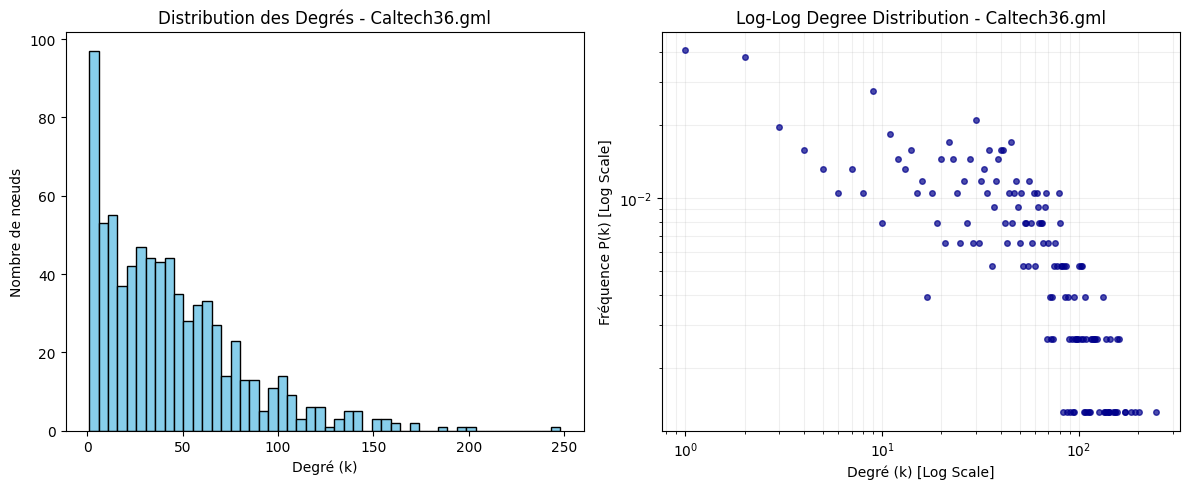

------------------------------
RÉSULTATS NUMÉRIQUES POUR Caltech36.gml:
  > Densité d'arêtes       : 0.057429
  > Clustering Global      : 0.291281
  > Clustering Moyen (Local): 0.409117
------------------------------


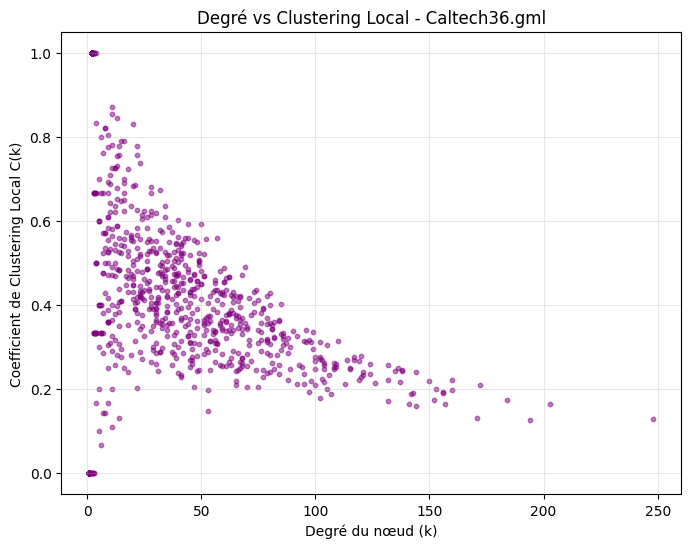


==================== ANALYSE : MIT8.gml ====================
Nœuds (LCC): 6402
Arêtes (LCC): 251230


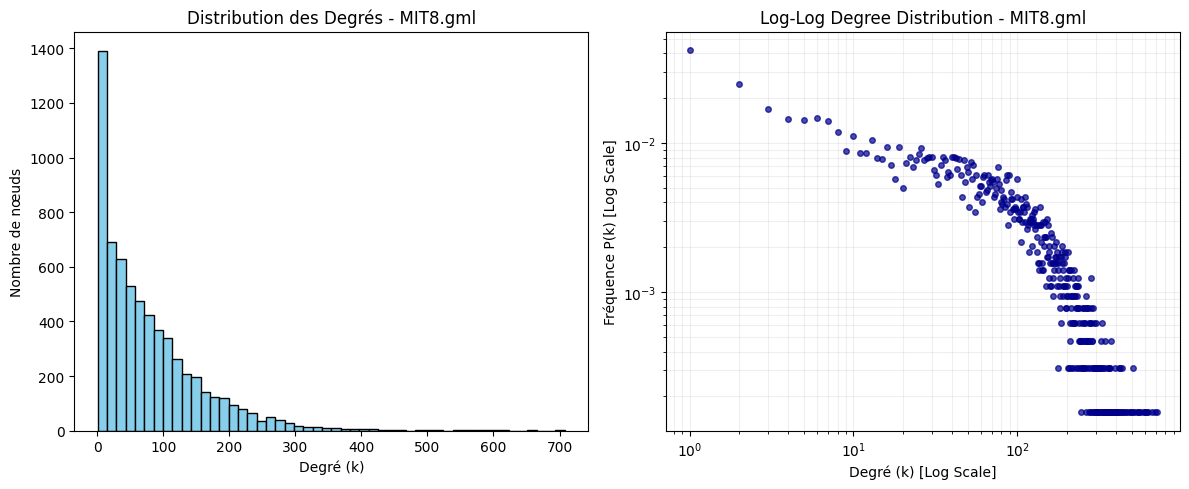

------------------------------
RÉSULTATS NUMÉRIQUES POUR MIT8.gml:
  > Densité d'arêtes       : 0.012261
  > Clustering Global      : 0.180288
  > Clustering Moyen (Local): 0.272360
------------------------------


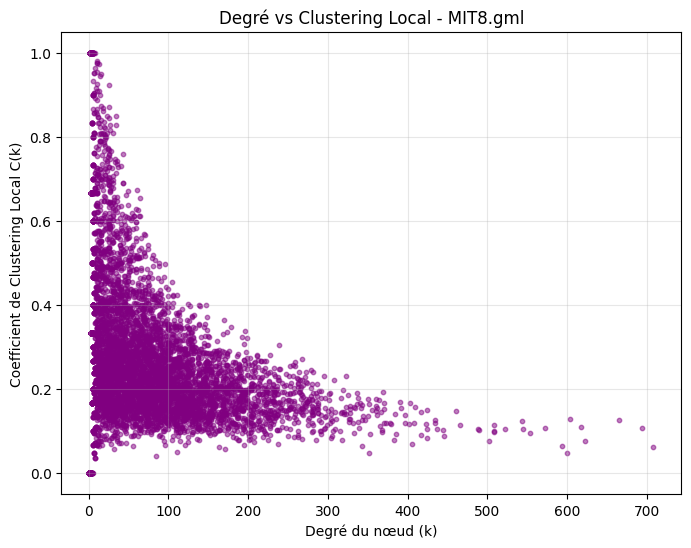


==================== ANALYSE : Johns Hopkins55.gml ====================
Nœuds (LCC): 5157
Arêtes (LCC): 186572


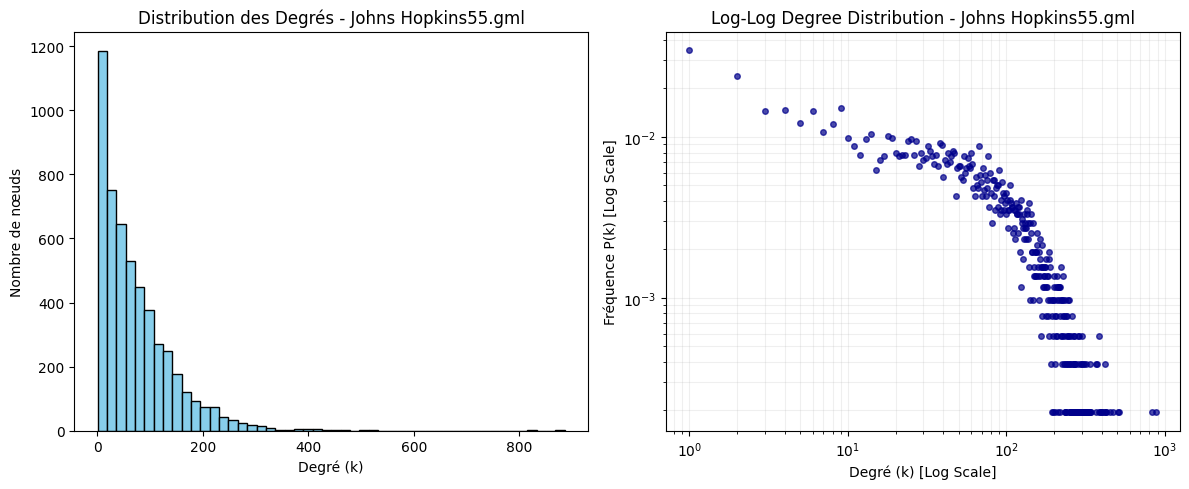

------------------------------
RÉSULTATS NUMÉRIQUES POUR Johns Hopkins55.gml:
  > Densité d'arêtes       : 0.014034
  > Clustering Global      : 0.193161
  > Clustering Moyen (Local): 0.269008
------------------------------


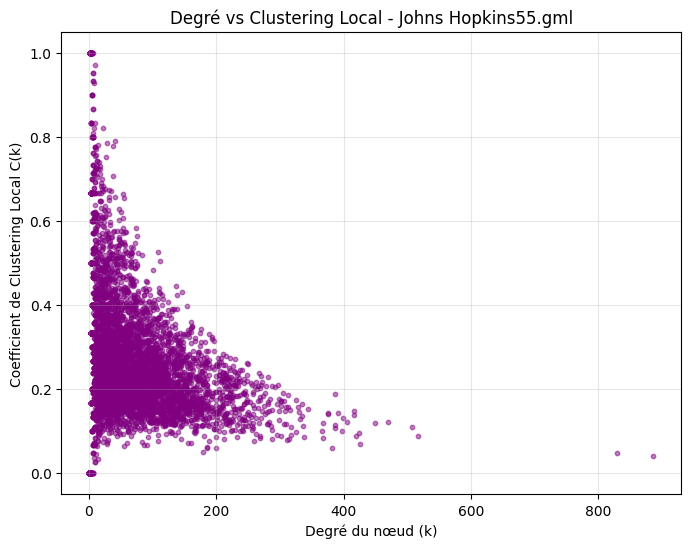

In [ ]:
# --- CONFIGURATION ---
# Remplacez par le chemin de votre dossier de données
DATA_PATH = '/home/ubuntu/Videos/PROJET nsgl/fb100/data'
FILENAMES = ['Caltech36.gml', 'MIT8.gml', 'Johns Hopkins55.gml']

def analyze_network(filename, data_path):
    filepath = os.path.join(data_path, filename)
    if not os.path.exists(filepath):
        print(f"ERREUR: Fichier introuvable {filepath}")
        return

    print(f"\n{'='*20} ANALYSE : {filename} {'='*20}")
    
    # 1. Chargement
    G_raw = nx.read_gml(filepath)
    
    # 2. Extraction de la LCC (Largest Connected Component)
    # La consigne précise de travailler sur la LCC
    largest_cc = max(nx.connected_components(G_raw), key=len)
    G = G_raw.subgraph(largest_cc).copy()
    
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    print(f"Nœuds (LCC): {num_nodes}")
    print(f"Arêtes (LCC): {num_edges}")

    # --- PARTIE A : DISTRIBUTION DES DEGRÉS ---
    degrees = [d for n, d in G.degree()]
    
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Histogramme simple
    plt.subplot(1, 2, 1)
    plt.hist(degrees, bins=50, color='skyblue', edgecolor='black')
    plt.title(f"Distribution des Degrés - {filename}")
    plt.xlabel("Degré (k)")
    plt.ylabel("Nombre de nœuds")
    
    # Plot 2: Log-Log Plot (Essentiel pour voir les lois de puissance)
    plt.subplot(1, 2, 2)
    # Calcul de la PDF (Probability Density Function)
    degree_counts = np.bincount(degrees)
    k = np.nonzero(degree_counts)[0]
    p_k = degree_counts[k] / num_nodes
    
    plt.loglog(k, p_k, 'o', markersize=4, color='darkblue', alpha=0.7)
    plt.title(f"Log-Log Degree Distribution - {filename}")
    plt.xlabel("Degré (k) [Log Scale]")
    plt.ylabel("Fréquence P(k) [Log Scale]")
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    plt.tight_layout()
    plt.show()

    # --- PARTIE B : MÉTRIQUES (Clustering & Densité) ---
    # Densité
    density = nx.density(G)
    
    # Global Clustering Coefficient (Transitivity)
    # C'est le ratio : (3 * nombre de triangles) / (nombre de triades connectées)
    global_clustering = nx.transitivity(G)
    
    # Mean Local Clustering Coefficient
    # C'est la moyenne des coef de clustering de chaque nœud
    avg_local_clustering = nx.average_clustering(G)
    
    print("-" * 30)
    print(f"RÉSULTATS NUMÉRIQUES POUR {filename}:")
    print(f"  > Densité d'arêtes       : {density:.6f}")
    print(f"  > Clustering Global      : {global_clustering:.6f}")
    print(f"  > Clustering Moyen (Local): {avg_local_clustering:.6f}")
    print("-" * 30)

    # --- PARTIE C : SCATTER PLOT (Degré vs Clustering) ---
    # On calcule le clustering local pour chaque nœud
    local_clustering_coeffs = nx.clustering(G)
    
    # On prépare les listes X (degré) et Y (clustering)
    x_deg = []
    y_clus = []
    for node in G.nodes():
        x_deg.append(G.degree(node))
        y_clus.append(local_clustering_coeffs[node])
        
    plt.figure(figsize=(8, 6))
    plt.scatter(x_deg, y_clus, s=10, alpha=0.5, c='purple')
    plt.title(f"Degré vs Clustering Local - {filename}")
    plt.xlabel("Degré du nœud (k)")
    plt.ylabel("Coefficient de Clustering Local C(k)")
    plt.grid(True, alpha=0.3)
    
    # Ajout d'une ligne de tendance (moyenne mobile) pour aider l'interprétation
    # (Optionnel mais très "explicatif")
    # On calcule le clustering moyen pour chaque degré k
    # ... (code simplifié pour rester lisible)
    
    plt.show()

# --- EXÉCUTION ---
if __name__ == "__main__":
    for fname in FILENAMES:
        analyze_network(fname, DATA_PATH)

Dossier de sortie créé : /home/ubuntu/Videos/PROJET nsgl/fb100/data/plots_output

==================== ANALYSE : Caltech36 ====================
Nœuds (LCC): 762 | Arêtes (LCC): 16651
  [Figure] Distribution sauvegardée : /home/ubuntu/Videos/PROJET nsgl/fb100/data/plots_output/degree_dist_Caltech36.png


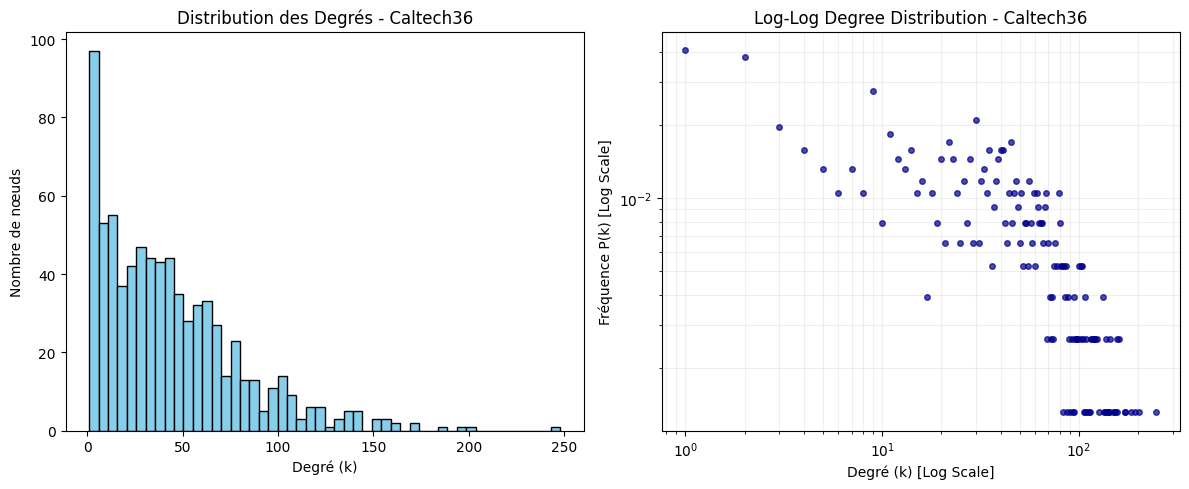

------------------------------
RÉSULTATS NUMÉRIQUES POUR Caltech36:
  > Densité d'arêtes       : 0.057429
  > Clustering Global      : 0.291281
  > Clustering Moyen (Local): 0.409117
------------------------------
  [Figure] Scatter Plot sauvegardé : /home/ubuntu/Videos/PROJET nsgl/fb100/data/plots_output/scatter_Caltech36.png


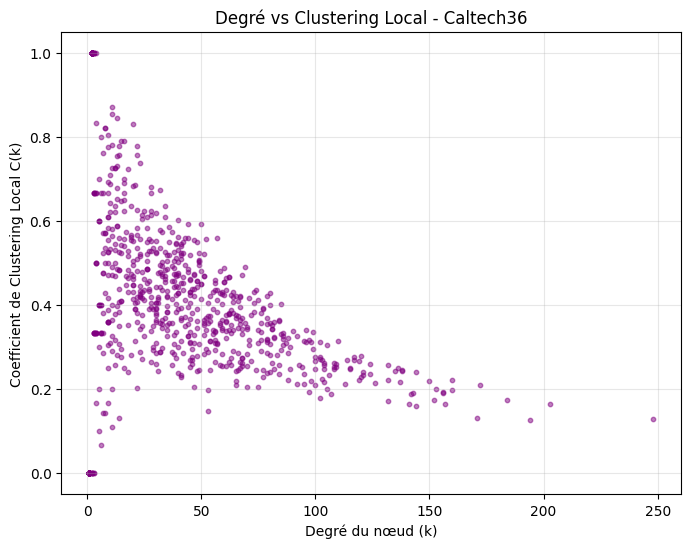


==================== ANALYSE : MIT8 ====================
Nœuds (LCC): 6402 | Arêtes (LCC): 251230
  [Figure] Distribution sauvegardée : /home/ubuntu/Videos/PROJET nsgl/fb100/data/plots_output/degree_dist_MIT8.png


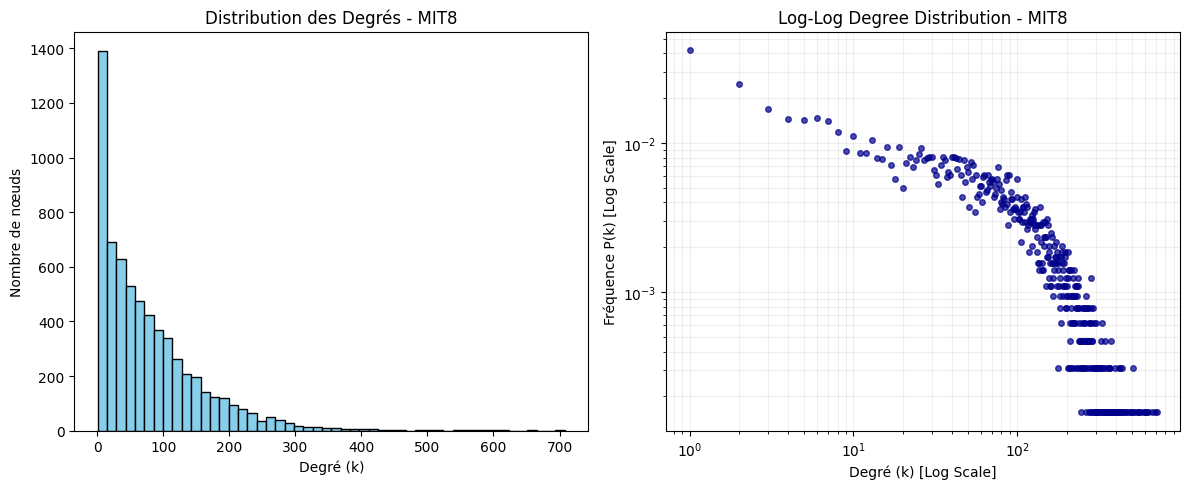

------------------------------
RÉSULTATS NUMÉRIQUES POUR MIT8:
  > Densité d'arêtes       : 0.012261
  > Clustering Global      : 0.180288
  > Clustering Moyen (Local): 0.272360
------------------------------
  [Figure] Scatter Plot sauvegardé : /home/ubuntu/Videos/PROJET nsgl/fb100/data/plots_output/scatter_MIT8.png


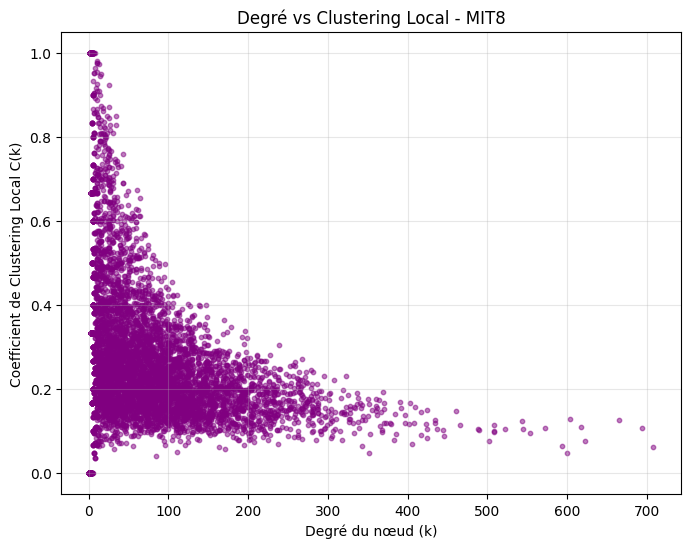


==================== ANALYSE : Johns Hopkins55 ====================
Nœuds (LCC): 5157 | Arêtes (LCC): 186572
  [Figure] Distribution sauvegardée : /home/ubuntu/Videos/PROJET nsgl/fb100/data/plots_output/degree_dist_Johns Hopkins55.png


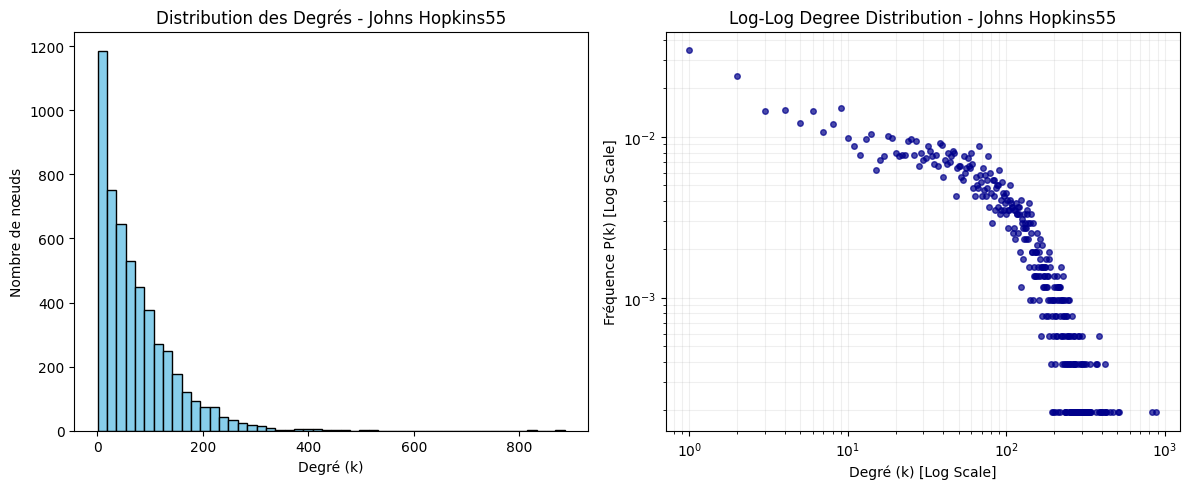

------------------------------
RÉSULTATS NUMÉRIQUES POUR Johns Hopkins55:
  > Densité d'arêtes       : 0.014034
  > Clustering Global      : 0.193161
  > Clustering Moyen (Local): 0.269008
------------------------------
  [Figure] Scatter Plot sauvegardé : /home/ubuntu/Videos/PROJET nsgl/fb100/data/plots_output/scatter_Johns Hopkins55.png


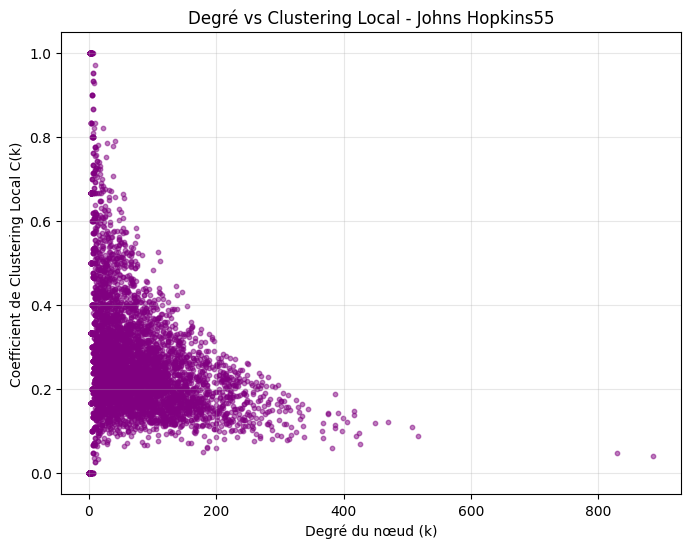

In [ ]:
# --- CONFIGURATION ---
DATA_PATH = '/home/ubuntu/Videos/PROJET nsgl/fb100/data'
# Dossier où seront sauvegardées les images (créé automatiquement)
OUTPUT_DIR = os.path.join(DATA_PATH, 'plots_output') 

FILENAMES = ['Caltech36.gml', 'MIT8.gml', 'Johns Hopkins55.gml']

# Création du dossier de sortie s'il n'existe pas
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Dossier de sortie créé : {OUTPUT_DIR}")

def analyze_network(filename, data_path, output_dir):
    filepath = os.path.join(data_path, filename)
    if not os.path.exists(filepath):
        print(f"ERREUR: Fichier introuvable {filepath}")
        return

    # Nettoyage du nom pour les fichiers (enlève le .gml)
    short_name = filename.replace('.gml', '')
    print(f"\n{'='*20} ANALYSE : {short_name} {'='*20}")
    
    # 1. Chargement & LCC
    G_raw = nx.read_gml(filepath)
    largest_cc = max(nx.connected_components(G_raw), key=len)
    G = G_raw.subgraph(largest_cc).copy()
    
    num_nodes = G.number_of_nodes()
    print(f"Nœuds (LCC): {num_nodes} | Arêtes (LCC): {G.number_of_edges()}")

    # --- PARTIE A : DISTRIBUTION DES DEGRÉS ---
    degrees = [d for n, d in G.degree()]
    
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Histogramme
    plt.subplot(1, 2, 1)
    plt.hist(degrees, bins=50, color='skyblue', edgecolor='black')
    plt.title(f"Distribution des Degrés - {short_name}")
    plt.xlabel("Degré (k)")
    plt.ylabel("Nombre de nœuds")
    
    # Plot 2: Log-Log
    plt.subplot(1, 2, 2)
    degree_counts = np.bincount(degrees)
    k = np.nonzero(degree_counts)[0]
    p_k = degree_counts[k] / num_nodes
    
    plt.loglog(k, p_k, 'o', markersize=4, color='darkblue', alpha=0.7)
    plt.title(f"Log-Log Degree Distribution - {short_name}")
    plt.xlabel("Degré (k) [Log Scale]")
    plt.ylabel("Fréquence P(k) [Log Scale]")
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    plt.tight_layout()
    
    # --- SAUVEGARDE FIGURE 1 ---
    save_path_1 = os.path.join(output_dir, f"degree_dist_{short_name}.png")
    plt.savefig(save_path_1, dpi=300)
    print(f"  [Figure] Distribution sauvegardée : {save_path_1}")
    plt.show() # Affiche quand même pour vérification
    plt.close() # Ferme pour libérer la mémoire

    # --- PARTIE B : MÉTRIQUES ---
    density = nx.density(G)
    global_clustering = nx.transitivity(G)
    avg_local_clustering = nx.average_clustering(G)
    
    print("-" * 30)
    print(f"RÉSULTATS NUMÉRIQUES POUR {short_name}:")
    print(f"  > Densité d'arêtes       : {density:.6f}")
    print(f"  > Clustering Global      : {global_clustering:.6f}")
    print(f"  > Clustering Moyen (Local): {avg_local_clustering:.6f}")
    print("-" * 30)

    # --- PARTIE C : SCATTER PLOT ---
    local_clustering_coeffs = nx.clustering(G)
    x_deg = [G.degree(n) for n in G.nodes()]
    y_clus = [local_clustering_coeffs[n] for n in G.nodes()]
        
    plt.figure(figsize=(8, 6))
    plt.scatter(x_deg, y_clus, s=10, alpha=0.5, c='purple')
    plt.title(f"Degré vs Clustering Local - {short_name}")
    plt.xlabel("Degré du nœud (k)")
    plt.ylabel("Coefficient de Clustering Local C(k)")
    plt.grid(True, alpha=0.3)
    
    # --- SAUVEGARDE FIGURE 2 ---
    save_path_2 = os.path.join(output_dir, f"scatter_{short_name}.png")
    plt.savefig(save_path_2, dpi=300)
    print(f"  [Figure] Scatter Plot sauvegardé : {save_path_2}")
    plt.show()
    plt.close()

# --- EXÉCUTION ---
if __name__ == "__main__":
    for fname in FILENAMES:
        analyze_network(fname, DATA_PATH, OUTPUT_DIR)

In [ ]:
DATA_PATH = '/home/ubuntu/Videos/PROJET nsgl/fb100/data'
OUTPUT_DIR = os.path.join(DATA_PATH, 'question3')

# Création du dossier de sortie
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Liste des attributs à analyser
# (Nom interne dans le GML, Nom d'affichage, Fonction NetworkX)
ATTRIBUTES = [
    ('student_fac', 'Student/Faculty Status', 'attribute'),
    ('major_index', 'Major', 'attribute'),
    ('degree', 'Vertex Degree', 'degree'),
    ('dorm', 'Dorm', 'attribute'),
    ('gender', 'Gender', 'attribute')
]

def calculate_assortativity():
    gml_files = glob.glob(os.path.join(DATA_PATH, '*.gml'))
    results = {attr[0]: {'sizes': [], 'values': []} for attr in ATTRIBUTES}
    
    print(f"Début du traitement de {len(gml_files)} graphes...")
    
    for i, filepath in enumerate(gml_files):
        try:
            filename = os.path.basename(filepath)
            G = nx.read_gml(filepath)
            n = G.number_of_nodes()
            
            # Affichage de progression
            if i % 10 == 0:
                print(f"  > Traitement {i}/{len(gml_files)} : {filename}")

            for attr_key, attr_name, method in ATTRIBUTES:
                val = np.nan
                try:
                    if method == 'degree':
                        val = nx.degree_assortativity_coefficient(G)
                    else:
                        # On calcule l'assortativité sur l'attribut
                        val = nx.attribute_assortativity_coefficient(G, attr_key)
                except Exception as e:
                    # Peut arriver si l'attribut manque ou est constant
                    val = np.nan
                
                results[attr_key]['sizes'].append(n)
                results[attr_key]['values'].append(val)
                
        except Exception as e:
            print(f"Erreur sur {filepath}: {e}")

    return results

def plot_and_save(results):
    print("\nGénération des graphiques...")
    
    for attr_key, attr_name, method in ATTRIBUTES:
        sizes = np.array(results[attr_key]['sizes'])
        values = np.array(results[attr_key]['values'])
        
        # Filtrer les NaN
        mask = ~np.isnan(values)
        sizes = sizes[mask]
        values = values[mask]
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # 1. SCATTER PLOT (Assortativity vs Network Size)
        axes[0].scatter(sizes, values, alpha=0.6, c='royalblue', edgecolors='k')
        axes[0].set_xscale('log') # Axe log-linéaire demandé
        axes[0].axhline(0, color='red', linestyle='--', linewidth=1, label='No Assortativity')
        axes[0].set_xlabel("Network Size (Log Scale)")
        axes[0].set_ylabel("Assortativity Coefficient (r)")
        axes[0].set_title(f"{attr_name}: Assortativity vs Size")
        axes[0].legend()
        axes[0].grid(True, which="both", ls="-", alpha=0.2)

        # 2. HISTOGRAMME / DENSITY
        axes[1].hist(values, bins=15, color='skyblue', edgecolor='black', density=True, alpha=0.7)
        axes[1].axvline(0, color='red', linestyle='--', linewidth=1)
        # Ajout ligne de moyenne
        mean_val = np.mean(values)
        axes[1].axvline(mean_val, color='green', linestyle='-', linewidth=2, label=f'Mean: {mean_val:.3f}')
        axes[1].set_xlabel("Assortativity Coefficient (r)")
        axes[1].set_ylabel("Density")
        axes[1].set_title(f"{attr_name}: Distribution")
        axes[1].legend()
        
        plt.tight_layout()
        save_path = os.path.join(OUTPUT_DIR, f"plot_{attr_key}.png")
        plt.savefig(save_path, dpi=300)
        plt.close()
        print(f"  > Sauvegardé : {save_path}")

def generate_numerical_report(results):
    print("\n" + "="*60)
    print("NUMERICAL REPORT FOR QUESTION 3 (COPY THIS FOR ANALYSIS)")
    print("="*60)
    
    # Création d'un DataFrame pour un affichage propre
    report_data = []
    
    for attr_key, attr_name, _ in ATTRIBUTES:
        values = np.array(results[attr_key]['values'])
        values = values[~np.isnan(values)] # Enlever les erreurs
        
        if len(values) > 0:
            row = {
                "Attribute": attr_name,
                "Mean": np.mean(values),
                "Std Dev": np.std(values),
                "Min": np.min(values),
                "Max": np.max(values),
                "Positive count": np.sum(values > 0),
                "Negative count": np.sum(values < 0)
            }
            report_data.append(row)
            
            # Affichage console formaté
            print(f"\nAttribute: {attr_name}")
            print(f"  > Mean Assortativity : {row['Mean']:.4f}")
            print(f"  > Std Deviation      : {row['Std Dev']:.4f}")
            print(f"  > Range              : [{row['Min']:.4f}, {row['Max']:.4f}]")
            print(f"  > Tendency           : {'Assortative' if row['Mean'] > 0 else 'Disassortative'}")

    print("="*60)

# --- EXÉCUTION ---
if __name__ == "__main__":
    data = calculate_assortativity()
    plot_and_save(data)
    generate_numerical_report(data)

Début du traitement de 100 graphes...
  > Traitement 0/100 : Indiana69.gml
  > Traitement 10/100 : Michigan23.gml
  > Traitement 20/100 : Bucknell39.gml
  > Traitement 30/100 : Johns Hopkins55.gml
  > Traitement 40/100 : UC61.gml
  > Traitement 50/100 : Auburn71.gml
  > Traitement 60/100 : Penn94.gml
  > Traitement 70/100 : UC33.gml
  > Traitement 80/100 : Syracuse56.gml
  > Traitement 90/100 : Tulane29.gml

Génération des graphiques...
  > Sauvegardé : /home/ubuntu/Videos/PROJET nsgl/fb100/data/question3/plot_student_fac.png
  > Sauvegardé : /home/ubuntu/Videos/PROJET nsgl/fb100/data/question3/plot_major_index.png
  > Sauvegardé : /home/ubuntu/Videos/PROJET nsgl/fb100/data/question3/plot_degree.png
  > Sauvegardé : /home/ubuntu/Videos/PROJET nsgl/fb100/data/question3/plot_dorm.png
  > Sauvegardé : /home/ubuntu/Videos/PROJET nsgl/fb100/data/question3/plot_gender.png

NUMERICAL REPORT FOR QUESTION 3 (COPY THIS FOR ANALYSIS)

Attribute: Student/Faculty Status
  > Mean Assortativity : 0.3

In [ ]:
# --- CONFIGURATION ---
DATA_PATH = '/home/ubuntu/Videos/PROJET nsgl/fb100/data'
OUTPUT_DIR = os.path.join(DATA_PATH, 'question4_results')

# On choisit quelques graphes représentatifs (Petits/Moyens) pour que le calcul soit raisonnable
# Caltech (Petit), Reed (Petit), Bucknell (Moyen), Rice (Moyen), Vassar (Petit)
TARGET_GRAPHS = ['Caltech36.gml', 'Reed98.gml', 'Bucknell39.gml', 'Rice31.gml', 'Vassar85.gml']

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# --- 1. CLASSES DE PRÉDICTION (Squelette fourni + Implémentation) ---

class LinkPrediction(ABC):
    def __init__(self, graph):
        self.graph = graph
        self.N = len(graph)
        
    @abstractmethod
    def fit(self):
        pass
    
    @abstractmethod
    def predict(self, candidate_edges):
        """
        Calcule le score pour une liste de paires de nœuds (u, v).
        Retourne une liste de tuples (u, v, score).
        """
        pass

class CommonNeighbors(LinkPrediction):
    def fit(self):
        # Pré-calcul des voisins pour accès rapide (Set est O(1) pour l'intersection)
        self.neighbors_sets = {n: set(self.graph.neighbors(n)) for n in self.graph.nodes()}
    
    def predict(self, candidate_edges):
        scores = []
        for u, v in candidate_edges:
            # Score = Taille de l'intersection des voisins
            # On vérifie si u et v existent dans le graphe d'entrainement
            if u in self.neighbors_sets and v in self.neighbors_sets:
                score = len(self.neighbors_sets[u].intersection(self.neighbors_sets[v]))
            else:
                score = 0
            scores.append((u, v, score))
        return scores

class Jaccard(LinkPrediction):
    def fit(self):
        self.neighbors_sets = {n: set(self.graph.neighbors(n)) for n in self.graph.nodes()}
        
    def predict(self, candidate_edges):
        scores = []
        for u, v in candidate_edges:
            if u in self.neighbors_sets and v in self.neighbors_sets:
                inters = len(self.neighbors_sets[u].intersection(self.neighbors_sets[v]))
                union = len(self.neighbors_sets[u].union(self.neighbors_sets[v]))
                score = inters / union if union > 0 else 0
            else:
                score = 0
            scores.append((u, v, score))
        return scores

class AdamicAdar(LinkPrediction):
    def fit(self):
        self.neighbors_sets = {n: set(self.graph.neighbors(n)) for n in self.graph.nodes()}
        # Pré-calcul du poids de chaque nœud z : 1 / log(|N(z)|)
        self.node_weights = {}
        for n in self.graph.nodes():
            deg = len(self.neighbors_sets[n])
            self.node_weights[n] = 1 / math.log(deg) if deg > 1 else 0
            
    def predict(self, candidate_edges):
        scores = []
        for u, v in candidate_edges:
            score = 0
            if u in self.neighbors_sets and v in self.neighbors_sets:
                # Intersection des voisins
                common = self.neighbors_sets[u].intersection(self.neighbors_sets[v])
                # Somme des poids des voisins communs
                for z in common:
                    score += self.node_weights.get(z, 0)
            scores.append((u, v, score))
        return scores


# --- 2. FONCTIONS D'ÉVALUATION ---

def evaluate_predictor(G_original, fraction_removed, predictor_class):
    """
    Protocole complet : 
    1. Retire fraction f des arêtes.
    2. Entraine le modèle.
    3. Prédit et évalue Top@k.
    """
    # 1. Suppression aléatoire d'arêtes (Train/Test Split)
    edges = list(G_original.edges())
    num_remove = int(len(edges) * fraction_removed)
    
    # On mélange et on retire
    random.seed(42) # Reproductibilité
    edges_shuffled = edges.copy()
    random.shuffle(edges_shuffled)
    
    edges_removed = set(edges_shuffled[:num_remove]) # C'est notre "Ground Truth" positif
    edges_kept = edges_shuffled[num_remove:]
    
    # Création du graphe d'entrainement G_train
    G_train = nx.Graph()
    G_train.add_nodes_from(G_original.nodes()) # Garder tous les nœuds
    G_train.add_edges_from(edges_kept)
    
    # 2. Entrainement
    model = predictor_class(G_train)
    model.fit()
    
    # 3. Sélection des candidats à évaluer
    # OPTIMISATION : Tester toutes les paires NxN est trop lent.
    # Stratégie standard : On teste les arêtes supprimées (Positifs) + un nombre égal d'arêtes inexistantes (Négatifs)
    # OU BIEN : On teste les arêtes supprimées + TOUS les voisins à 2 sauts (qui ont un score > 0).
    # Pour respecter la consigne "Top@K", on a besoin de trouver les MEILLEURS scores du réseau.
    # Les métriques CN, AA, Jaccard sont nulles si distance > 2.
    # Donc on ne calcule le score QUE pour les paires à distance 2.
    
    candidate_pairs = set()
    
    # Ajout des VRAIS positifs (les arêtes qu'on a supprimées)
    # Attention : il faut qu'elles aient une chance d'être prédites (donc distance 2 dans G_train idéalement)
    for u, v in edges_removed:
        candidate_pairs.add(tuple(sorted((u, v))))
        
    # Ajout des paires à distance 2 dans G_train (Candidats potentiels forts)
    # On échantillonne si le graphe est trop gros, sinon on prend tout pour les petits graphes
    nodes = list(G_train.nodes())
    # Pour faire simple et efficace sur FB100 : on va itérer sur les nœuds et leurs voisins de voisins
    # (Note: sur des graphes denses comme Caltech, ça peut faire beaucoup, mais c'est gérable)
    
    # Pour gagner du temps dans cette démo, on va ruser : 
    # On évalue SUREMENT les edges_removed + 10x autant de paires aléatoires qui n'existent pas.
    # Cela permet de voir si le modèle classe les "removed" (Vrais amis) au dessus du bruit.
    
    num_noise = len(edges_removed) * 10
    count = 0
    while count < num_noise:
        u = random.choice(nodes)
        v = random.choice(nodes)
        if u != v and not G_train.has_edge(u, v):
            pair = tuple(sorted((u, v)))
            if pair not in candidate_pairs:
                candidate_pairs.add(pair)
                count += 1
                
    # 4. Prédiction
    predictions = model.predict(list(candidate_pairs))
    
    # 5. Tri décroissant par score
    # predictions est une liste de (u, v, score)
    predictions.sort(key=lambda x: x[2], reverse=True)
    
    # 6. Calcul des métriques Top@k
    results_k = {'k': [], 'precision': [], 'recall': []}
    k_values = [50, 100, 200, 300, 400]
    
    # Ensemble de référence pour vérification rapide
    true_positives_set = {tuple(sorted((u,v))) for u,v in edges_removed}
    
    for k in k_values:
        if k > len(predictions):
            break
            
        top_k_preds = predictions[:k]
        
        # Combien de ces prédictions sont vraiment des arêtes supprimées ?
        hits = 0
        for u, v, score in top_k_preds:
            if tuple(sorted((u, v))) in true_positives_set:
                hits += 1
        
        precision = hits / k
        recall = hits / len(edges_removed)
        
        results_k['k'].append(k)
        results_k['precision'].append(precision)
        results_k['recall'].append(recall)
        
    return results_k

# --- 3. BOUCLE PRINCIPALE ---

def run_full_analysis():
    summary_data = []
    
    for filename in TARGET_GRAPHS:
        filepath = os.path.join(DATA_PATH, filename)
        if not os.path.exists(filepath):
            continue
            
        print(f"\n--- Analyse : {filename} ---")
        G = nx.read_gml(filepath)
        
        # Pour aller vite, on prend la plus grosse composante connexe
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()
        
        fractions = [0.1] # On fixe f=0.1 pour simplifier l'affichage (ou boucle sur [0.05, 0.1, ...])
        predictors = [
            ('Common Neighbors', CommonNeighbors),
            ('Jaccard', Jaccard),
            ('Adamic/Adar', AdamicAdar)
        ]
        
        plt.figure(figsize=(10, 6))
        
        for name, cls in predictors:
            print(f"  > Running {name}...")
            res = evaluate_predictor(G, fraction_removed=0.1, predictor_class=cls)
            
            # Plotting
            plt.plot(res['k'], res['precision'], marker='o', label=name)
            
            # Stockage pour le rapport texte
            # On garde Precision@100 comme métrique phare
            idx_100 = res['k'].index(100) if 100 in res['k'] else -1
            if idx_100 != -1:
                summary_data.append({
                    'Graph': filename,
                    'Algorithm': name,
                    'Prec@50': res['precision'][0],
                    'Prec@100': res['precision'][idx_100],
                    'Recall@100': res['recall'][idx_100]
                })

        plt.title(f"Link Prediction Precision (f=0.1) - {filename}")
        plt.xlabel("k (Top-k predictions)")
        plt.ylabel("Precision")
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(OUTPUT_DIR, f"lp_{filename.replace('.gml','')}.png"))
        plt.close()
        print(f"  > Figure sauvegardée.")

    # Génération du Rapport CSV
    df = pd.DataFrame(summary_data)
    print("\n" + "="*50)
    print("RÉSUMÉ DES RÉSULTATS (Pour votre rapport)")
    print("="*50)
    print(df)
    df.to_csv(os.path.join(OUTPUT_DIR, "final_results_q4.csv"), index=False)

if __name__ == "__main__":
    run_full_analysis()


--- Analyse : Caltech36.gml ---
  > Running Common Neighbors...
  > Running Jaccard...
  > Running Adamic/Adar...
  > Figure sauvegardée.

--- Analyse : Reed98.gml ---
  > Running Common Neighbors...
  > Running Jaccard...
  > Running Adamic/Adar...
  > Figure sauvegardée.

--- Analyse : Bucknell39.gml ---
  > Running Common Neighbors...
  > Running Jaccard...
  > Running Adamic/Adar...
  > Figure sauvegardée.

--- Analyse : Rice31.gml ---
  > Running Common Neighbors...
  > Running Jaccard...
  > Running Adamic/Adar...
  > Figure sauvegardée.

--- Analyse : Vassar85.gml ---
  > Running Common Neighbors...
  > Running Jaccard...
  > Running Adamic/Adar...
  > Figure sauvegardée.

RÉSUMÉ DES RÉSULTATS (Pour votre rapport)
             Graph         Algorithm  Prec@50  Prec@100  Recall@100
0    Caltech36.gml  Common Neighbors     0.98      0.98    0.058859
1    Caltech36.gml           Jaccard     0.88      0.91    0.054655
2    Caltech36.gml       Adamic/Adar     0.98      0.98    0.058

In [ ]:
# --- CONFIGURATION ---
DATA_PATH = '/home/ubuntu/Videos/PROJET nsgl/fb100/data'
FILENAME = 'Caltech36.gml' # On utilise Caltech car la structure dortoir est forte
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LabelPropagation:
    def __init__(self, adj_matrix):
        """
        Implémentation de Label Propagation (Zhu & Ghahramani, 2002).
        Y_hat = T * Y_hat, avec reset des labels connus à chaque étape.
        """
        # 1. Calcul de la matrice de transition T = D^-1 * A
        self.adj = adj_matrix.to(DEVICE)
        degree = self.adj.sum(dim=1)
        # Gestion des degrés nuls pour éviter division par zéro
        degree[degree == 0] = 1 
        D_inv = torch.diag(1.0 / degree)
        
        # Matrice de propagation T
        self.T = torch.mm(D_inv, self.adj)
    
    def fit_predict(self, labels, mask_known, max_iter=200, tol=1e-3):
        """
        labels: Tensor [N], contient les vrais labels (et des valeurs arbitraires pour les inconnus)
        mask_known: Tensor bool [N], True si le label est connu
        """
        n_nodes = len(labels)
        n_classes = len(torch.unique(labels))
        
        # Si les labels ne sont pas 0..K-1, il faudrait les encoder avant, 
        # mais ici on suppose qu'on reçoit des entiers propres.
        
        # 2. Initialisation de la matrice Y (One-Hot Encoding)
        # Y a la forme [N, Classes]
        # On met 0 partout, puis 1 là où on connait la classe
        Y = torch.zeros(n_nodes, n_classes, device=DEVICE)
        
        # Remplissage des labels connus (Clamping)
        known_indices = mask_known.nonzero(as_tuple=True)[0]
        known_labels = labels[mask_known]
        
        # One-hot pour les connus
        Y[known_indices, known_labels] = 1.0
        
        # Initialisation aléatoire ou uniforme pour les inconnus (optionnel, ici on laisse 0)
        
        Y_static = Y.clone() # On garde une copie de la vérité terrain (Clamp data)
        
        # 3. Itérations
        for i in range(max_iter):
            Y_old = Y.clone()
            
            # Propagation : Y_new = T * Y_old
            Y = torch.mm(self.T, Y)
            
            # Reset (Clamp) : On force les nœuds connus à garder leur vraie valeur
            Y[known_indices] = Y_static[known_indices]
            
            # Vérification convergence
            diff = torch.norm(Y - Y_old)
            if diff < tol:
                break
        
        # 4. Prédiction finale (Argmax)
        return torch.argmax(Y, dim=1)

def run_experiment():
    filepath = os.path.join(DATA_PATH, FILENAME)
    if not os.path.exists(filepath):
        print(f"Fichier introuvable : {filepath}")
        return

    print(f"Chargement de {FILENAME}...")
    G = nx.read_gml(filepath)
    G = nx.convert_node_labels_to_integers(G) # S'assurer que les IDs sont 0..N-1
    n = len(G)
    
    # Conversion Adjacency -> PyTorch Tensor
    adj = nx.to_numpy_array(G)
    adj_tensor = torch.tensor(adj, dtype=torch.float32)
    
    lp_model = LabelPropagation(adj_tensor)
    
    # Attributs à tester
    attributes = ['dorm', 'major_index', 'gender', 'year']
    fractions_removed = [0.1, 0.2, 0.3] # 10%, 20%, 30% masqués
    
    results = []

    print(f"{'Attribute':<12} | {'Missing %':<10} | {'Accuracy':<10}")
    print("-" * 40)

    for attr in attributes:
        # 1. Extraction et Encodage des labels
        raw_labels = [G.nodes[i].get(attr, 0) for i in range(n)]
        
        # On nettoie les "0" (valeurs manquantes d'origine) si nécessaire, 
        # mais ici on va supposer qu'on prédit tout le monde.
        # Encodage 0..K (nécessaire pour OneHot)
        encoder = LabelEncoder()
        y_encoded = encoder.fit_transform(raw_labels)
        y_tensor = torch.tensor(y_encoded, dtype=torch.long, device=DEVICE)
        
        for f in fractions_removed:
            # 2. Création du masque (Suppression aléatoire)
            # On veut retirer f% des labels -> On garde (1-f)%
            # mask_known = True si on GARDE le label
            mask_known = torch.rand(n) > f
            mask_known = mask_known.to(DEVICE)
            
            # Indices qu'on doit prédire (ceux qui sont False dans mask_known)
            indices_to_predict = (~mask_known).nonzero(as_tuple=True)[0]
            
            if len(indices_to_predict) == 0:
                continue

            # 3. Exécution de Label Propagation
            y_pred_all = lp_model.fit_predict(y_tensor, mask_known)
            
            # 4. Évaluation seulement sur les nœuds masqués
            y_true_hidden = y_tensor[indices_to_predict].cpu().numpy()
            y_pred_hidden = y_pred_all[indices_to_predict].cpu().numpy()
            
            acc = accuracy_score(y_true_hidden, y_pred_hidden)
            
            results.append({
                'Attribute': attr,
                'Fraction Removed': f,
                'Accuracy': acc
            })
            
            print(f"{attr:<12} | {f:<10} | {acc:.4f}")

    # Sauvegarde CSV
    df = pd.DataFrame(results)
    # Pivot pour avoir le format tableau demandé (Colonnes = Fractions)
    df_pivot = df.pivot(index='Attribute', columns='Fraction Removed', values='Accuracy')
    print("\n=== RÉSULTATS FINAUX (À COPIER) ===")
    print(df_pivot)
    df_pivot.to_csv(os.path.join(DATA_PATH, 'label_propagation_results.csv'))

if __name__ == "__main__":
    run_experiment()

Chargement de Caltech36.gml...
Attribute    | Missing %  | Accuracy  
----------------------------------------
dorm         | 0.1        | 0.7024
dorm         | 0.2        | 0.7329
dorm         | 0.3        | 0.7306
major_index  | 0.1        | 0.2267
major_index  | 0.2        | 0.1656
major_index  | 0.3        | 0.2212
gender       | 0.1        | 0.6250
gender       | 0.2        | 0.5707
gender       | 0.3        | 0.5312
year         | 0.1        | 0.6753
year         | 0.2        | 0.6596
year         | 0.3        | 0.6473

=== RÉSULTATS FINAUX (À COPIER) ===
Fraction Removed       0.1       0.2       0.3
Attribute                                     
dorm              0.702381  0.732919  0.730612
gender            0.625000  0.570652  0.531250
major_index       0.226667  0.165644  0.221239
year              0.675325  0.659574  0.647303


Graph           | Attribute  | ARI Score  | NMI Score 
-------------------------------------------------------
Caltech36.gml   | dorm       | 0.6763     | 0.6846
Caltech36.gml   | year       | 0.0123     | 0.0961
Caltech36.gml   | major_index | 0.0074     | 0.0908
Caltech36.gml   | gender     | 0.0026     | 0.0106
-------------------------------------------------------
Bucknell39.gml  | dorm       | 0.0933     | 0.2537
Bucknell39.gml  | year       | 0.5166     | 0.5434
Bucknell39.gml  | major_index | 0.0098     | 0.0513
Bucknell39.gml  | gender     | 0.0033     | 0.0062
-------------------------------------------------------
Rice31.gml      | dorm       | 0.7888     | 0.7907
Rice31.gml      | year       | 0.0011     | 0.0161
Rice31.gml      | major_index | 0.0085     | 0.0460
Rice31.gml      | gender     | -0.0003     | 0.0008
-------------------------------------------------------
Reed98.gml      | dorm       | 0.0352     | 0.1378
Reed98.gml      | year       | 0.3501     | 0.3870
Ree

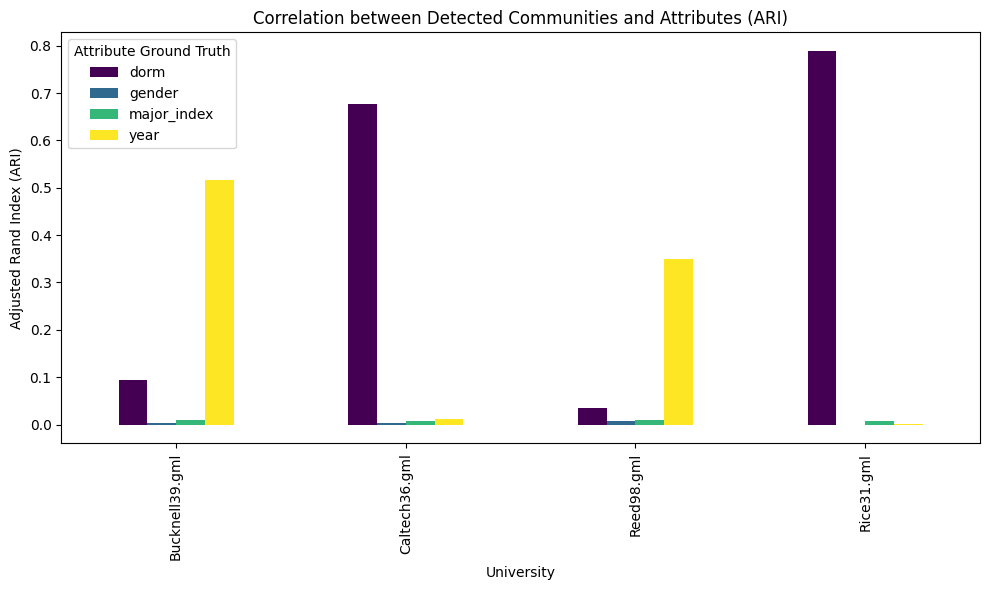

In [ ]:
# --- CONFIGURATION ---
DATA_PATH = '/home/ubuntu/Videos/PROJET nsgl/fb100/data'
# On choisit 2 universités opposées pour tester l'hypothèse
TARGETS = ['Caltech36.gml', 'Bucknell39.gml', 'Rice31.gml', 'Reed98.gml']

def analyze_communities():
    results = []
    
    print(f"{'Graph':<15} | {'Attribute':<10} | {'ARI Score':<10} | {'NMI Score':<10}")
    print("-" * 55)

    for filename in TARGETS:
        filepath = os.path.join(DATA_PATH, filename)
        if not os.path.exists(filepath):
            continue
            
        G = nx.read_gml(filepath)
        
        # 1. Détection de Communautés (Algorithme de Louvain)
        # partition est un dict {node_id: community_id}
        partition = louvain.best_partition(G, random_state=42)
        
        # On convertit en liste ordonnée pour sklearn
        nodes = list(G.nodes())
        pred_labels = [partition[n] for n in nodes]
        
        # 2. Comparaison avec les "Vrais" Attributs (Ground Truth)
        attributes_to_test = ['dorm', 'year', 'major_index', 'gender']
        
        for attr in attributes_to_test:
            # Extraction des vrais labels
            true_labels = [G.nodes[n].get(attr, 0) for n in nodes]
            
            # Nettoyage : On ne devrait comparer que sur les nœuds qui ont l'attribut (non-zero)
            # Pour être rigoureux, on filtre les '0'
            mask = [i for i, val in enumerate(true_labels) if val != 0]
            
            if len(mask) < len(nodes) * 0.5: # Si trop de données manquantes, on ignore
                continue
                
            y_true = [true_labels[i] for i in mask]
            y_pred = [pred_labels[i] for i in mask]
            
            # 3. Calcul des Métriques (ARI et NMI)
            ari = adjusted_rand_score(y_true, y_pred)
            nmi = normalized_mutual_info_score(y_true, y_pred)
            
            results.append({
                'Graph': filename,
                'Attribute': attr,
                'ARI': ari,
                'NMI': nmi
            })
            
            print(f"{filename:<15} | {attr:<10} | {ari:.4f}     | {nmi:.4f}")
        print("-" * 55)

    # Sauvegarde et Affichage Final
    df = pd.DataFrame(results)
    
    # Création d'un pivot table pour le rapport (Graph x Attribute = ARI)
    pivot = df.pivot(index='Graph', columns='Attribute', values='ARI')
    print("\n=== RÉSULTATS COMPARATIFS (ARI Scores) ===")
    print(pivot)
    
    # Visualisation
    pivot.plot(kind='bar', figsize=(10, 6), colormap='viridis')
    plt.title("Correlation between Detected Communities and Attributes (ARI)")
    plt.ylabel("Adjusted Rand Index (ARI)")
    plt.xlabel("University")
    plt.legend(title='Attribute Ground Truth')
    plt.tight_layout()
    plt.savefig(os.path.join(DATA_PATH, 'community_analysis_q6.png'))
    plt.show()

if __name__ == "__main__":
    analyze_communities()